INTRODUCTION, UNDERLYING OVERVIEW:
The following lines of codes will show the price time series of our underlying and its characteristics (log returns distribution and QQ-Plot normality tests)

Saving Group4_12139_prices.xlsx to Group4_12139_prices.xlsx


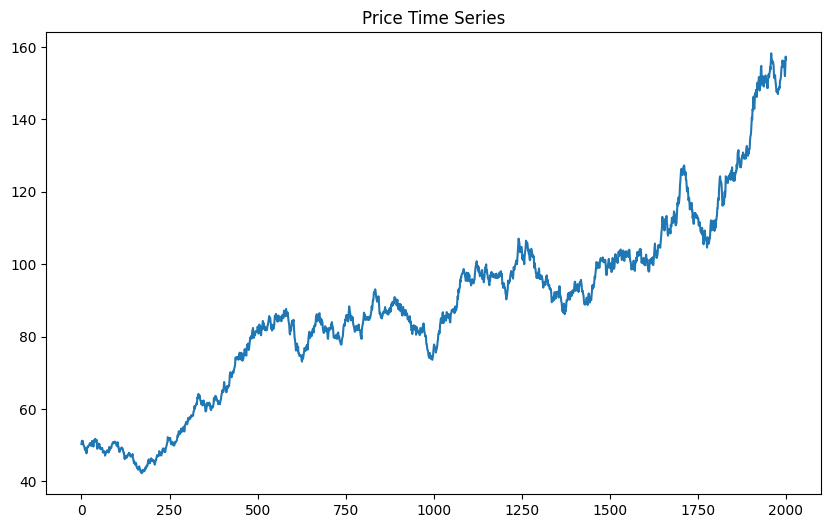

In [ ]:
from google.colab import files
uploaded = files.upload()
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd
import seaborn as sns


data= pd.read_excel('Group4_12139_prices.xlsx')
data['X(t)'].plot(title='Price Time Series', figsize=(10, 6))
plt.show()

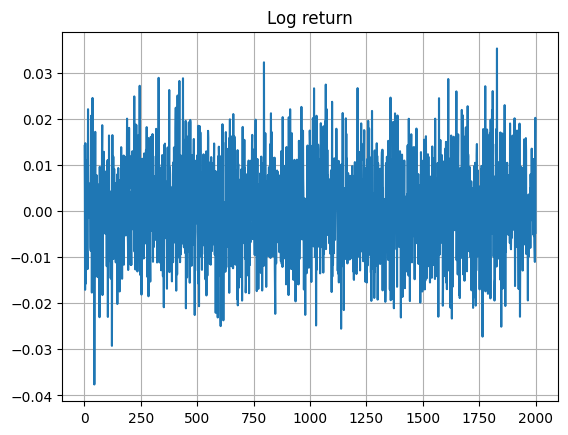

         t        X(t)      Xt_r
0        0   50.324972       NaN
1        1   51.040350  0.014115
2        2   51.259455  0.004284
3        3   50.390318 -0.017101
4        4   51.136945  0.014708
...    ...         ...       ...
1996  1996  153.672837 -0.009437
1997  1997  151.983636 -0.011053
1998  1998  154.219155  0.014602
1999  1999  157.366910  0.020205
2000  2000  156.621236 -0.004750

[2001 rows x 3 columns]


In [ ]:
data['Xt_r']= np.log(data['X(t)'] / data['X(t)'].shift(1))
plt.plot(data['t'], data['Xt_r'])
plt.title('Log return')
plt.grid(True)
plt.show()
print(data)
Xt_r=data['Xt_r'][1:].to_numpy()

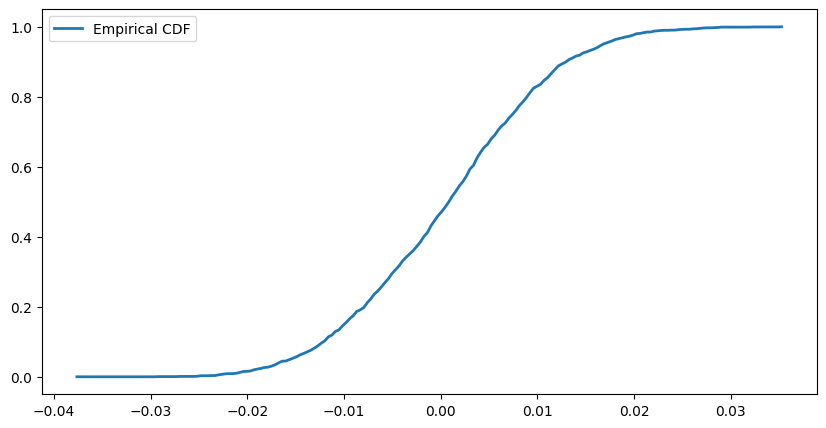

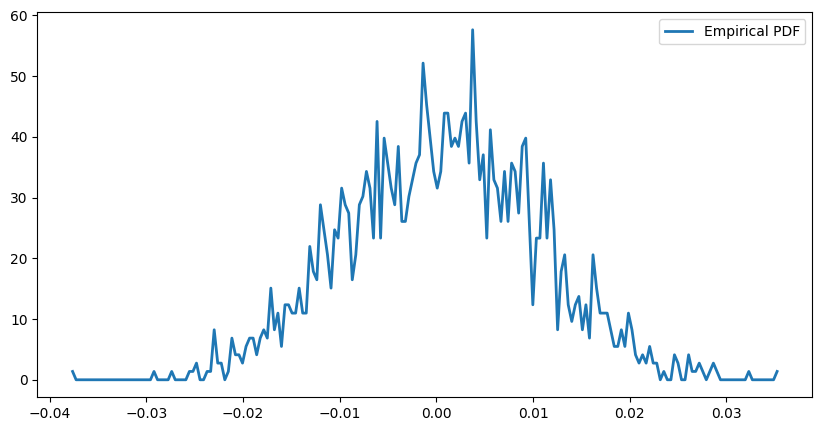

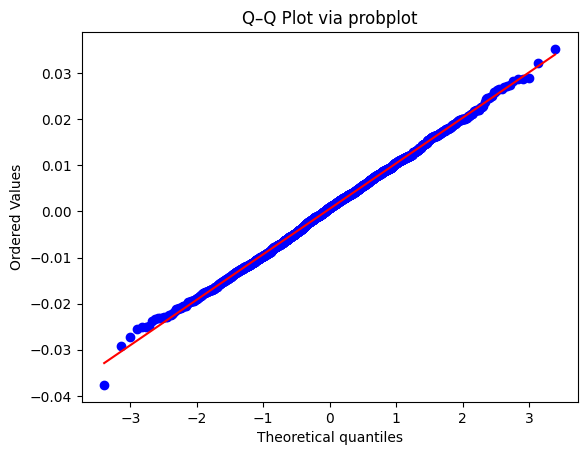

In [ ]:
Xt_max = np.max(Xt_r)
Xt_min = np.min(Xt_r)
n = Xt_r.shape[0]
d = 200
deltas = np.linspace(Xt_min, Xt_max, d)
CDF_hat = np.zeros(shape=d)

for i in range(int(d)):
    CDF_hat[i] = sum(Xt_r <= deltas[i]) / n

plt.figure(figsize=(10, 5))
plt.plot(deltas, CDF_hat, linewidth=2, label='Empirical CDF')
plt.legend()
plt.show()

#PDF
Deltastep= (Xt_max-Xt_min)/d
epsilon=Deltastep/2
PDF_hat =np.zeros(shape=d)
for i in range(int(d)):
    PDF_hat[i] = ((sum( Xt_r <= deltas[i]+epsilon)/n) - (sum( Xt_r<= deltas[i]-epsilon)/n) )/(2*epsilon)
plt.figure(figsize=(10, 5))
plt.plot(deltas, PDF_hat, linewidth=2, label='Empirical PDF')
plt.legend()
plt.show()

from scipy.stats import probplot

probplot(Xt_r, dist="norm", plot=plt)
plt.title("Q–Q Plot via probplot")
plt.show()

All these plots confirm that the log returns are normally distributed, suggesting that the underlying could indeed be log-normal, as assumed under the GBM approach. However, let’s stick with the log-normal assumption without making any specific assumptions about the GBM dynamics. By examining the theoretical SDE and the market data, we can infer that the underlying is a stock price

Point number 2: The following lines of code shows the implementation of the Euler discretization of our SDE, which is resolved for the shocks component. Our goal is to check and correctly assess if the simulated N(0,1) shocks are also empirically normally distributed. The implementation has been done with an educated guess of the parameters k, sigma and gamma, amounting respectively to 8%, 15% and 1. This guess is relative to the underlying time series pattern, which shows a marked drift and volatility component.

1       1.464680
2       0.418766
3      -1.821011
4       1.528105
5      -1.687162
          ...   
1996   -1.023765
1997   -1.192410
1998    1.516729
1999    2.117769
2000   -0.533207
Name: X(t), Length: 2000, dtype: float64
3.7480492850867484 -3.9272493009942493


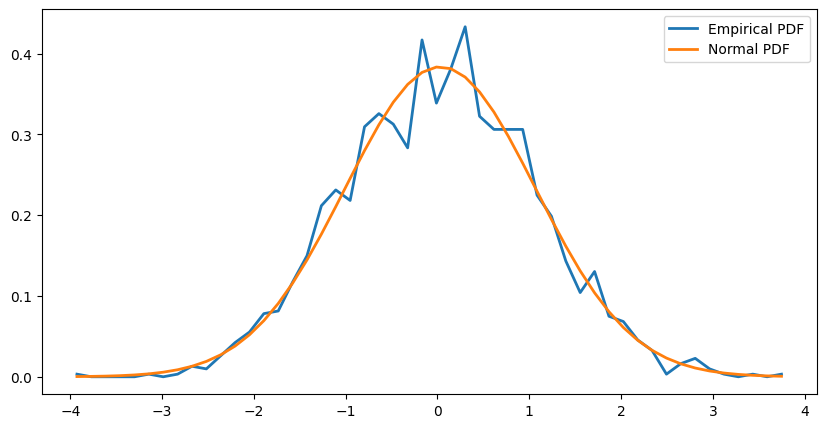

0.031244352481423186 1.0804633618543993


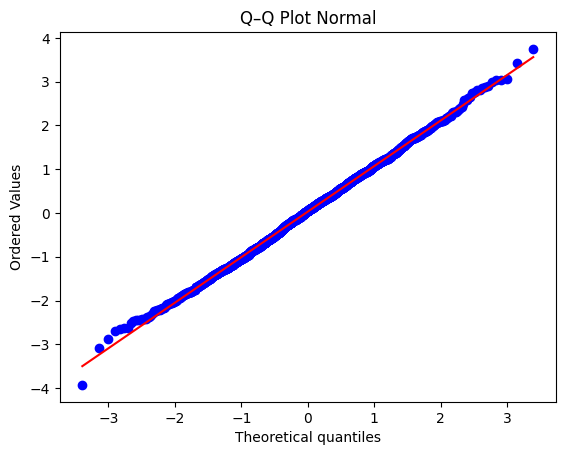

In [ ]:
dt=1/250
k_guess = 0.08
sigma_guess = 0.15
gamma_guess= 1
shocks= (data['X(t)'] - data['X(t)'].shift(1) - data['X(t)'].shift(1)*k_guess*dt)/(sigma_guess*data['X(t)'].shift(1)**(gamma_guess)*np.sqrt(dt))
shocks=shocks.dropna()
print(shocks)

shocks_max = np.max(shocks)
shocks_min = np.min(shocks)
print(shocks_max, shocks_min)
d = 50
deltas= np.linspace(shocks_min,shocks_max, d)
Deltastep= (shocks_max-shocks_min)/d
n = shocks.shape[0]
sigma_hat = shocks.std()
mu_hat = shocks.mean()

epsilon=Deltastep/2
PDF_hat =np.zeros(shape=d)
PDF_norm =np.zeros(shape=d)


for i in range(int(d)):
    PDF_hat[i] = ((np.sum( shocks<= deltas[i]+epsilon)/n) - (np.sum( shocks<= deltas[i]-epsilon)/n) )/(2*epsilon)
    PDF_norm[i]= norm.pdf( deltas[i], mu_hat, sigma_hat)

plt.figure(figsize=(10, 5))
plt.plot(deltas, PDF_hat, linewidth=2, label='Empirical PDF')
plt.plot(deltas, PDF_norm, linewidth=2, label='Normal PDF')
plt.legend()
plt.show()

mean= np.mean(shocks)
variance= np.std(shocks)**2
print(mean, variance)

probplot(shocks, dist="norm", plot=plt)
plt.title("Q–Q Plot Normal")
plt.show()

By looking at the empirical PDF and the QQ-plot, we can confirm that they are actually looking normally distributed with mean zero and variance 1, N(0,1).

Point number 3: The following lines of codes show some hands calculation on the first moment and variance of our discretized X(t+ΔT) distribution (to be found in the loglikelihood function under the variable name of loc and scale). Then the MLE estimation of the parameters has been implemented by the usual minimize function.

In [ ]:
from scipy.stats import norm
from scipy.optimize import minimize

Xt=data['X(t)'][0:].to_numpy()
dt=1/250

def loglikelihood(Theta, X, dt):
      k = Theta[0]
      sigma = Theta[1]
      gamma = Theta[2]
      logL=0
      for i in range(1,len(X)):
          x_previous = X[i-1]
          loc= x_previous+ k*x_previous*dt
          scale= sigma*(x_previous**(gamma))*np.sqrt(dt)
          logL += np.log(norm.pdf(X[i], loc = loc, scale = scale))
      return -logL

bnds = ((0,None), (0,1),(0, 1.5))
ig= (0.08, 0.15, 1)
MLE = minimize(loglikelihood, ig, args=(Xt, dt), bounds=bnds, method='Nelder-Mead')
k_MLE, sigma_MLE, gamma_MLE = MLE.x
print(k_MLE, sigma_MLE, gamma_MLE)

0.1544499523977796 0.1347650356116999 1.0328339855969422


The final 3 best fit of most likely set of parameters, are k =0.1544499523977796, sigma= 0.1347650356116999 and gamma=1.0328339855969422. This values are reasonable. The k and sigma shows a marked drift component and a good volatility behaviour of our underlying (which is in line with our educated guess of a stock as underlying), moreover, the gamma value diverges slightly from the classical GBM parameter value (=1), confirming non-explosive behaviour similar to a GBM, but not exactly a GBM.

Point number 4: The following lines of codes shoes the computation algorithm of a derivatives inception price written on our underlying, specifically an European Put option. The computation has been conducted by a daily Monte Carlo simulation run with the founded MLE parameters estimation and with a number of simulations of 10 000.

In [ ]:
X0= Xt[-1]
T = 1.2
K=X0
r= 0.04
k= 0.1544499523977796
sigma= 0.1347650356116999
gamma= 1.0328339855969422
c = int(T*250)
dt=1/250
NSim= 10000


def MC_BSPutOption(NSim, k, sigma, gamma, dt, K, r, T, c, X0):
    X=np.zeros(shape=(NSim, c+1))
    X[:,0]=X0
    for i in range(int(NSim)):
        for j in range(int(c)):
            X[i,j+1]= X[i,j] + k*X[i,j]*dt + sigma*(X[i,j]**(gamma))*np.sqrt(dt)*np.random.normal(0,1)
    # print(X.shape)
    output = np.zeros(shape=2)
    discPayoff = np.exp(-r*T)*np.maximum(0,K-X[:,-1])
    output[0] = discPayoff.mean()
    output[1] = discPayoff.std()*1.96/np.sqrt(NSim)

    return output
put_price = MC_BSPutOption(NSim, k, sigma, gamma, dt, K, r, T, c, X0)
print(put_price[0])

2.0807617920357737


With this number of simulations, the final put price is around 2.13

Point number 5: Now we compute the same european put price on our underlying, but by means of the Lattice discretization. The Lattice discretization has been run with 60 steps

156.62123647827673
Shape of X_sim: (61, 61)
            0           1           2           3           4           5   \
0   156.621236  160.186286  163.835211  167.570048  171.392888  175.305871   
1          inf  153.138075  156.621236  160.186286  163.835211  167.570048   
2          inf         inf  149.734862  153.138075  156.621236  160.186286   
3          inf         inf         inf  146.409705  149.734862  153.138075   
4          inf         inf         inf         inf  143.160758  146.409705   
..         ...         ...         ...         ...         ...         ...   
56         inf         inf         inf         inf         inf         inf   
57         inf         inf         inf         inf         inf         inf   
58         inf         inf         inf         inf         inf         inf   
59         inf         inf         inf         inf         inf         inf   
60         inf         inf         inf         inf         inf         inf   

            6      

<ipython-input-10-7d35d5f04bbd>:16: RuntimeWarning: divide by zero encountered in power
  X_sim= (f_X_sim)**(1/(1-gamma))


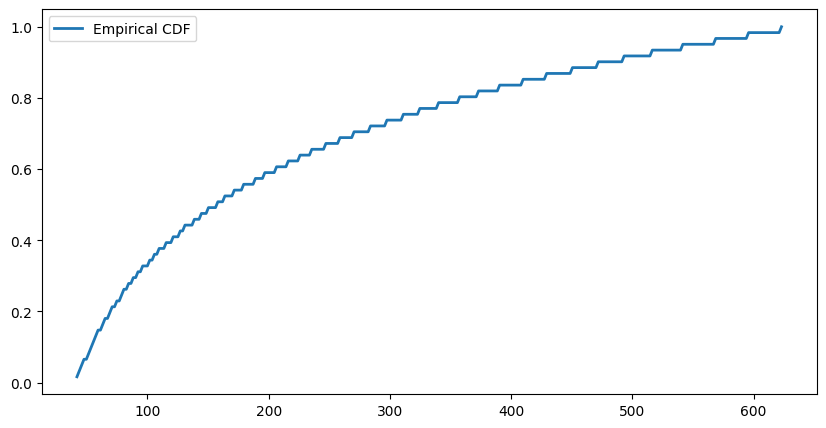

 state-probability matrix           0         1         2         3         4         5         6   \
0   0.562839  0.562784  0.562729  0.562674  0.562619  0.562564  0.562509   
1   0.000000  0.562894  0.562839  0.562784  0.562729  0.562674  0.562619   
2   0.000000  0.000000  0.562949  0.562894  0.562839  0.562784  0.562729   
3   0.000000  0.000000  0.000000  0.563004  0.562949  0.562894  0.562839   
4   0.000000  0.000000  0.000000  0.000000  0.563059  0.563004  0.562949   
..       ...       ...       ...       ...       ...       ...       ...   
56  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
57  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
58  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
59  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
60  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          7         8         9   ...        51        52    

In [ ]:

#case gamma different from 1

gamma= 1.0328339855969422
dt=1/50
c= int(T*50)

X0= Xt[-1]
print(X0)
f_X_sim=np.zeros(shape=(c+1, c+1))
f_X_sim[0,0] = X0**(1-gamma)
print("Shape of X_sim:", f_X_sim.shape)

for i in range(int(c+1)):
  for j in range(i,int(c+1)):
          f_X_sim[i,j] = f_X_sim[0,0] + (j-2*i)*(-gamma+1)*sigma*np.sqrt(dt)
X_sim= (f_X_sim)**(1/(1-gamma))

df = pd.DataFrame(X_sim)
print(df)

#Just a check of the CDF

Xs_max = np.max(X_sim[:,-1])
Xs_min = np.min(X_sim[:,-1])
n = len(X_sim[:,-1])
d = 301
deltas = np.linspace(Xs_min, Xs_max, d)
CDF_hat = np.zeros(shape=d)

for i in range(int(d)):
    CDF_hat[i] = sum(X_sim[:,-1] <= deltas[i]) / n


plt.figure(figsize=(10, 5))
plt.plot(deltas, CDF_hat, linewidth=2, label='Empirical CDF')
plt.legend()
plt.show()

#Probability Matrix

prob= np.zeros(shape=(c+1, c+1))

for i in range(int(c+1)):
  for j in range(i,int(c+1)):
      a= (1-gamma)*f_X_sim[i,j]*k + 0.5*(1-gamma)*(-gamma)*(X_sim[i,j]**(gamma-1))*sigma**2
      prob[i,j]= np.maximum(0,np.minimum(1, 0.5 + (a*np.sqrt(dt))/(2*sigma*(1-gamma))))

prob = pd.DataFrame(prob)
print(' state-probability matrix',prob)

Eur_Put = np.zeros(shape=(c+1,c+1))

Eur_Put[:,-1] = np.maximum(0,K-X_sim[:,-1])

discFct = np.exp(-r*dt)

for i in range(int(c)):
  for j in range(int(c-i)):
      p_val = prob.iloc[j, c-i-1]
      Eur_Put[j, c-i-1] = discFct*( p_val*Eur_Put[j,c-i] +(1-p_val)*Eur_Put[j+1, c-i] )

Put_0_Lattice=Eur_Put[0,0]
prices= pd.DataFrame(Eur_Put)
print(prices)
print('put price:', Put_0_Lattice)
print(X_sim.shape)

All this plots above are just checks on our procedure's correctness. The relevant output is the Put price value, which amounts to 2.0478870804013423.

Point number 6: The same european put inception price is now computed by the PDE scheme approach. The values of the cuts of our discretized support have been chosen in such a way their ratio is infinitesimal (in the following lines we can found it on the stability check dt/dx**2). Our grid for the PDE scheme implementation has been built with the common european put boundaries (found under #Bounds, #bottom, #right, #left).

In [ ]:

Xmax = 5*X0

T=1.2
gamma= 1.0328339855969422

mt = 300
ms = 200

dt = T/mt
dx = Xmax/ms

print('Stability check for magnitude Delta t / Delta x ^2 :',dt/dx**2)

nodes_t = np.linspace(0,T,mt+1)
nodes_X = np.linspace(0,Xmax,ms+1)

# Bounds
G = np.zeros(shape=(mt+1,ms+1))

#bottom
G[-1,:] = np.maximum(0, K-nodes_X)

#right
G[:,-1] = 0

#left
G[:,0] = np.flip(K*np.exp(-r*nodes_t))

# Interior points
for i in range(1,mt+1):
  for j in range(1,ms):
    G[mt-i,j] = (G[mt-i+1,j]/dt -r*G[mt-i+1,j] + (G[mt-i+1,j+1]-G[mt-i+1,j-1])/(2*dx)*(k*j*dx)+0.5*sigma**2*(j*dx)**(2*gamma)*(G[mt-i+1,j+1]-2*G[mt-i+1,j]+G[mt-i+1,j-1])/(dx**2))*dt

# X0 is dx*5, so I want f(0, 40)

Grill = pd.DataFrame(G)
print(Grill)
P0_PDE= G[0,40]
print('put option price', P0_PDE)




Stability check for magnitude Delta t / Delta x ^2 : 0.0002609027624425131
            0           1           2           3           4           5    \
0    149.280992  144.788569  140.296767  135.804939  131.313112  126.821286   
1    149.304879  144.814514  140.324766  135.834994  131.345223  126.855451   
2    149.328770  144.840461  140.352768  135.865050  131.377333  126.889616   
3    149.352664  144.866411  140.380771  135.895107  131.409444  126.923780   
4    149.376563  144.892364  140.408776  135.925165  131.441554  126.957944   
..          ...         ...         ...         ...         ...         ...   
296  156.521031  152.598317  148.675611  144.752905  140.830199  136.907493   
297  156.546076  152.625159  148.704248  144.783337  140.862426  136.941516   
298  156.571126  152.652005  148.732888  144.813771  140.894655  136.975538   
299  156.596179  152.678854  148.761530  144.844207  140.926883  137.009560   
300  156.621236  152.705706  148.790175  144.874644  140

The inception european put price amounts to 2.0631833463956153

Comparison: the following line of codes show a visual comparison of the 3 inception put prices found with the Montecarlo approach, Lattice discretization and PDE scheme. The 95% confidence interval are also plotted, and the graph plots on its X-axes the number of simulations used.

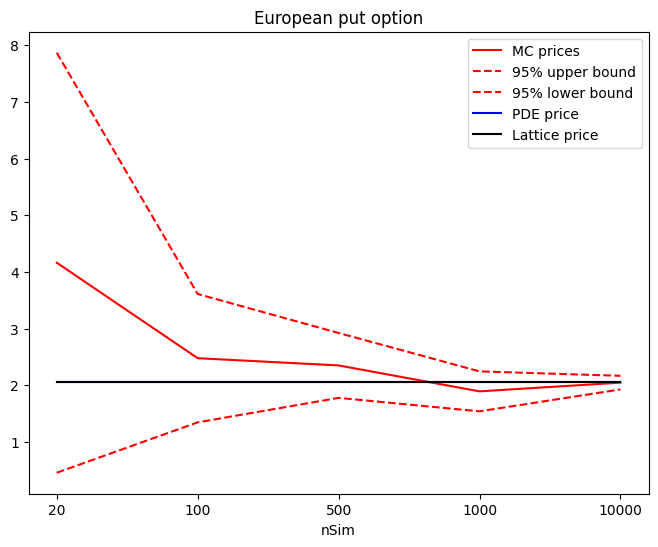

In [ ]:
NSim_roll = np.array([20, 100, 500, 1000, 10000])
MCprices = np.zeros(NSim_roll.shape)
MCradius = np.zeros(NSim_roll.shape)

c = int(T*250)
i = 0

dt= 1/250
for n in NSim_roll:
  tempOutput = MC_BSPutOption(n, k, sigma, gamma, dt, K, r, T, c, X0)
  MCprices[i] = tempOutput[0]
  MCradius[i] = tempOutput[1]
  i += 1

upper_Bound_MC = MCprices + MCradius
lower_bound = MCprices - MCradius

plt.figure(figsize=(8, 6))
plt.plot( MCprices,'r',label = "MC prices")
plt.plot(upper_Bound_MC,'r--', label = "95% upper bound")
plt.plot(lower_bound,'r--', label = "95% lower bound")
PDE_line = np.full_like(MCprices, P0_PDE)
Lattice_line = np.full_like(MCprices, Put_0_Lattice)
plt.plot(PDE_line, 'b', label="PDE price")
plt.plot(Lattice_line, 'k', label="Lattice price")
plt.xlabel('nSim')
plt.xticks(np.arange(0, NSim_roll.shape[0]), NSim_roll)
plt.title("European put option")
plt.legend()
plt.show()

As the number of simulation increases, the 3 methods seams to converge and always stay inside the 95% confidence interval

Punto 7 with PDE: The following lines of code show the computation of the American put inception price written on our underlying. We compute it under the PDE-scheme implementation.

In [ ]:
Xmax = 5*X0

T=1.2
gamma= 1.0328339855969422

mt = 300
ms = 200

dt = T/mt
dx = Xmax/ms

print('Stability check for magnitude Delta t / Delta x ^2 :',dt/dx**2)

nodes_t = np.linspace(0,T,mt+1)
nodes_X = np.linspace(0,Xmax,ms+1)

# Bounds
G = np.zeros(shape=(mt+1,ms+1))

#bottom
G[-1,:] = np.maximum(0, K-nodes_X)

#right
G[:,-1] = 0

#left
G[:,0] = np.flip(K*np.exp(-r*nodes_t))

# Interior points
for i in range(1,mt+1):
  for j in range(1,ms):
    G[mt-i,j] = np.maximum( ( (G[mt-i+1,j]/dt -r*G[mt-i+1,j] + (G[mt-i+1,j+1]-G[mt-i+1,j-1])/(2*dx)*(k*j*dx)+0.5*sigma**2*(j*dx)**(2*gamma)*(G[mt-i+1,j+1]-2*G[mt-i+1,j]+G[mt-i+1,j-1])/(dx**2))*dt) , np.maximum(K-j*dx, 0))

# X0 is dx*5, so I want f(0, 40)

Grill = pd.DataFrame(G)
print(Grill)
print('American put option price', G[0,40])

exercise_premium= G[0,40] - P0_PDE
print('Exercise premium:', exercise_premium)

Stability check for magnitude Delta t / Delta x ^2 : 0.0002609027624425131
            0           1           2           3           4           5    \
0    149.280992  152.705706  148.790175  144.874644  140.959113  137.043582   
1    149.304879  152.705706  148.790175  144.874644  140.959113  137.043582   
2    149.328770  152.705706  148.790175  144.874644  140.959113  137.043582   
3    149.352664  152.705706  148.790175  144.874644  140.959113  137.043582   
4    149.376563  152.705706  148.790175  144.874644  140.959113  137.043582   
..          ...         ...         ...         ...         ...         ...   
296  156.521031  152.705706  148.790175  144.874644  140.959113  137.043582   
297  156.546076  152.705706  148.790175  144.874644  140.959113  137.043582   
298  156.571126  152.705706  148.790175  144.874644  140.959113  137.043582   
299  156.596179  152.705706  148.790175  144.874644  140.959113  137.043582   
300  156.621236  152.705706  148.790175  144.874644  140

The inception price of such derivative amounts to 4.338504561766426, which is resonable compared to the European version of the Put, which costs around 2.1.

Punto 7 with Lattice (Extra): We compute the same american put price as before but this time with the Lattice approach.

(61, 61)
American put price: 4.353880413462737


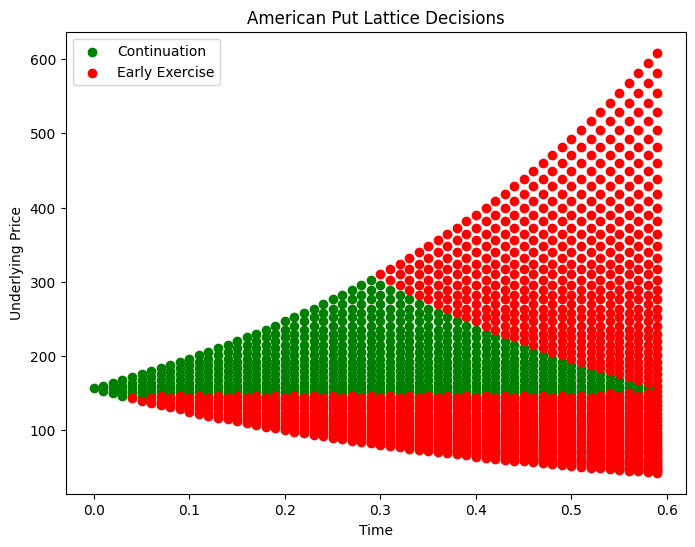

Exercise premium: 2.305993333061395


In [ ]:
c= int(T*50)
American_Put = np.zeros(shape=(c+1,c+1))
print(X_sim.shape)
American_Put[:,-1] = np.maximum(0,K-X_sim[:,-1])


dt=1/100

discFct = np.exp(-r*dt)
times_cont = []
vals_cont = []
times_exer = []
vals_exer = []

for i in range(int(c)):
  for j in range(int(c-i)):
      p_val = prob.iloc[j, c-i-1]
      IP= discFct*( p_val*American_Put[j,c-i] +(1-p_val)*American_Put[j+1, c-i] )
      CV= np.maximum(0,K-X_sim[j, c-i-1])
      American_Put[j, c-i-1] = np.maximum(IP, CV)
      t = dt * (c - i - 1)  # "time" on the x-axis
      S = X_sim[j, c - i - 1]  # underlying price on the y-axis
      if IP > CV:
          times_cont.append(t)
          vals_cont.append(S)
      else:
          times_exer.append(t)
          vals_exer.append(S)

AM_put= pd.DataFrame(American_Put)

print('American put price:', American_Put[0,0])

plt.figure(figsize=(8, 6))
plt.scatter(times_cont, vals_cont, c='green', label='Continuation')
plt.scatter(times_exer, vals_exer, c='red',   label='Early Exercise')
plt.xlabel('Time')
plt.ylabel('Underlying Price')
plt.title('American Put Lattice Decisions')
plt.legend()
plt.show()

exercise_premium= American_Put[0,0] - Put_0_Lattice
print('Exercise premium:', exercise_premium)

We can see that the American put price is around 4.35, similar to the PDE price found. The plot above shows the optimal exectution policy of such derivative. This plot, if at first impact can show a weird pattern (Early exercise claims in the up-right part of the pane, which is very different to the known optimal graphs of other american puts), in reality shows nothing else then the expected output shape of our strategy, but with "wrong" plots in the upper right part due to the explosivity of our Lattice algorithm.

Point number 8: The final point of the group assigment refers to the computation of the inception price of a Down and Out version of the european put previously analyzed. Such computation has been done by a Monte Carlo algorithm, imposing the "knocked out" condition during the paths of the simulations.

In [ ]:

X0 = Xt[-1]
T = 1.2
K = X0
r = 0.04
k= 0.1544499523977796
sigma= 0.1347650356116999
gamma = 1.0328339855969422
c = int(T * 250)
dt = 1 / 250
NSim = 1000
B = 140  #barrier


def MC_BSPutOption(NSim, k, sigma, gamma, dt, K, r, T, c, X0, B):
    X = np.zeros(shape=(NSim, c + 1))
    X[:, 0] = X0
    payoff = np.zeros(NSim)
    for i in range(int(NSim)):
        knocked_out = False
        for j in range(int(c)):
            X[i, j + 1] = X[i, j] + k * X[i, j] * dt + sigma * (X[i, j] ** (gamma)) * np.sqrt(dt) * np.random.normal(0,1)
            if X[i, j+1] <= B:
                knocked_out = True
                break
        if knocked_out:
            payoff[i] = 0
        else:
            payoff[i] = np.maximum(K - X[i, -1], 0)

    disc_payoff = np.exp(-r * T) * payoff
    output = np.zeros(shape=2)

    output[0] = np.mean(disc_payoff)
    output[1] = disc_payoff.std() * 1.96 / np.sqrt(NSim)


    return output
put_price = MC_BSPutOption(NSim, k, sigma, gamma, dt, K, r, T, c, X0, B)
print(put_price[0])

0.28010204658114796


The Down and Out put price is 0.28010204658114796, which is in line with the previously found european put price. Indeed, such Down and Out derivative, gives is a less claim rights w.r.t the european case.